In [51]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
%matplotlib inline

In [32]:
plt.style.use('classic')

# Task 1
Read the historical Bitcoin prices from the provided csv file (btchistorical.csv) and describe the
properties of the dataframe.

In [33]:
# Import the Data
btc = pd.read_csv("btchistorical.csv", parse_dates=["date"])
btc.columns = [c.replace(' ', '_') for c in btc.columns]

In [34]:
# Summary statistics
btc.describe()

,open,close,volume,high,low,market_cap
count,3073.000000,3073.000000,3.073000e+03,3073.000000,3073.000000,3.073000e+03
mean,11300.065097,11308.630346,1.395598e+10,11595.863515,10972.396817,2.080593e+11
std,16243.433760,16242.872749,1.954176e+10,16665.300947,15758.625212,3.066943e+11
min,176.897003,178.102997,2.857830e+06,211.731003,171.509995,2.444379e+09
25%,581.650024,581.645020,5.780140e+07,589.151001,571.814026,7.737830e+09
50%,5271.746394,5279.348211,4.390020e+09,5363.257523,5169.283391,9.321830e+10
75%,10588.184021,10594.493354,2.432216e+10,10847.256993,10291.694493,1.893255e+11
max,67549.735581,67566.830088,3.509679e+11,68789.625939,66382.061008,1.274831e+12


# Task 2
Construct the following ten predictors/factors based on the provided formulas. Where you need to
calculate a factor that needs price, use the closing price.

In [35]:
btc["MCAP"] = np.log(btc.market_cap)
btc["PRC"] = np.log(btc.close)
btc["MAXDPRC"] = btc.close.rolling(7).apply(lambda x: np.max(x))
# Momentum
for i in range(1,5):
    btc[f"r_{i},0"] = btc.close.rolling(i*7).apply(lambda x: x.iloc[-1]-x.iloc[0])
# TODO Past one-to-four-week return
#btc["r_4,1"] = np.NAN
# ?same value for all datapoints. Should this be done using a rolling mehtod?
btc["PRCVOL"] = list(map(lambda x: np.log(np.average(x.volume)) * x.close.iloc[0], btc.rolling(7)))
btc["STDPRCVOL"] = np.log(np.std(btc.PRCVOL))
btc["DAMIHUD"] = btc.close.rolling(2).apply(lambda x: np.abs((x.iloc[-1]-x.iloc[0])/(x.iloc[0])))

# Task 3
Calculate seven day return based on the closing price using the following formula

In [36]:
# Create 7 day return
btc["R7"] = btc.close.rolling(7).apply(lambda x: (x.iloc[-1]-x.iloc[0])/(x.iloc[0]))
btc.R7= btc.R7.shift(-7)

In [37]:
# Add 1-7 day lagged prices
for i in range(1,15):
    btc[f"close_lagged_{i}"] = btc.close.shift(periods=i)

In [38]:
# Drop all rows with NaN
btc_cut = btc.dropna()

# Task 4
Divide historical prices and volume (i.e., open, close, high, low, and volume) into training, validation, and testing samples and use linear regression, random forest, and support vector machine to investigate the performance of past prices for return prediction.

## Split Data

In [39]:
def data_split(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test

In [40]:
#X = btc_cut[["open", "close", "high", "low", "volume"]]
X = btc_cut.loc[:, [col not in ['date', 'market_cap', 'MCAP', 'PRC', 'MAXDPRC', 'r_1,0', 'r_2,0', 'r_3,0', 'r_4,0', 'PRCVOL', 'STDPRCVOL', 'DAMIHUD', 'R7'] for col in btc.columns]]

## Linear Regression

Strong correlation --> only cosider "open" and "volume"

<AxesSubplot:>

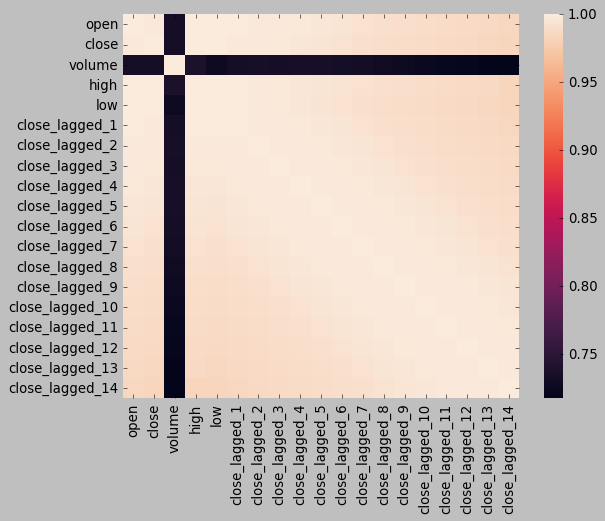

In [41]:
sns.heatmap(X.corr())

In [42]:
def lin_model(pred_vars:list):
    """Fit a linear model to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple(float, RegressionResultsWrapper): out of sample r2 score and fit
    """
    X = btc_cut[pred_vars]
    y = btc_cut.R7
    # 80/20 split
    X_train, X_test, y_train, y_test = data_split(X, y)
    # Train
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    fit = model.fit()
    #fit.summary()
    # Test
    X_test = sm.add_constant(X_test)
    pred = fit.predict(X_test)
    return r2_score(y_pred=pred, y_true=y_test), fit

In [43]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]
r2, fit = lin_model(pred_vars=pred_vars)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R7   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.715
Date:                Sun, 25 Dec 2022   Prob (F-statistic):            0.00123
Time:                        20:10:40   Log-Likelihood:                 2231.7
No. Observations:                2431   AIC:                            -4457.
Df Residuals:                    2428   BIC:                            -4440.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.002      5.394      0.000       0.008       0.018
close      -6.394e-07   1.75e-07     -3.647      0.000   -9.83e-07   -2.96e-07
volume       4.11e-13   1.43e-13      2.876      0.004    1.31e-13    6.91e-13
==============================================================================
Omnibus:                      201.425   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.584
Skew:                           0.416   Prob(JB):                    2.13e-134
Kurtosis:                       5.320   Cond. No.                     3.06e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Checking all available Models using the powerset of all predictors
def powerset(s):
    """Generator for all subsets of a given set
    Source:
        https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

    Args:
         (list): set to construct subsets of

    Yields:
        list: subset
    """
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]


high = 0  
pred_vars = X.columns[:12]
for set in tqdm(powerset(pred_vars), total=2**len(pred_vars)):
    r2, fit = lin_model(set)
    """
    # Select model based on out of sample r2
    if r2 > high:
        high = r2
        best = fit
    """ 
    # Select model based on in sample adj r2
    if fit.rsquared_adj > high:
        high = r2
        best = fit
print(best.summary())
print(f"Out of sample R2 score: {r2}")

100%|██████████| 4096/4096 [00:23<00:00, 173.30it/s]

                            OLS Regression Results                            
Dep. Variable:                     R7   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.887
Date:                Sun, 25 Dec 2022   Prob (F-statistic):           0.000532
Time:                        20:11:04   Log-Likelihood:                 2233.8
No. Observations:                2431   AIC:                            -4460.
Df Residuals:                    2427   BIC:                            -4436.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0132      0.002      5.

## Random Forest

In [88]:
def random_forst(pred_vars:list):
    """Fit a random forest to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple: out of sample r2 score and model
    """
    # Get relevant predictors
    X = btc_cut[pred_vars]
    y = btc_cut.R7
    # 80/20 split
    X_train, X_test, y_train, y_test = data_split(X, y)
    # Train
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
    model = rf.fit(X=X_train, y=y_train)
    # Test
    pred = rf.predict(X_test)
    return r2_score(y_pred=pred, y_true=y_test), model

Out of sample R2 score: 0.0324780250593566


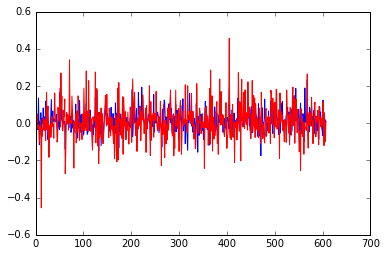

In [89]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]
r2, fit = random_forst(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

Out of sample R2 score: 0.3641613553229953


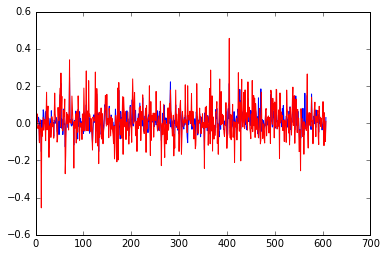

In [90]:
# Model with lagged prices
pred_vars = X.columns
r2, fit = random_forst(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

[Text(0.5, 1.0, 'Variable Importance')]

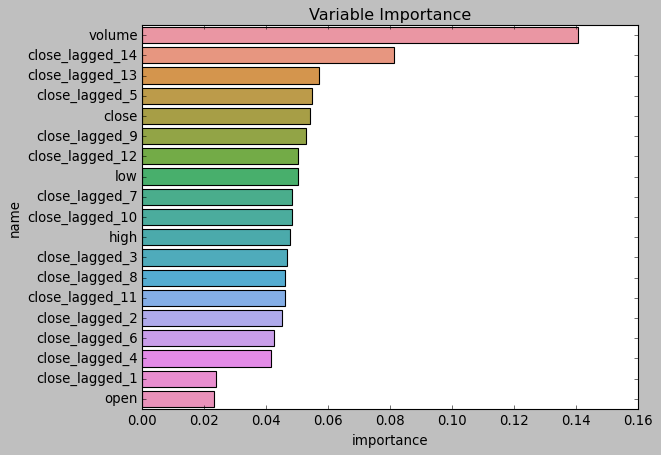

In [48]:
imp = pd.DataFrame({"importance":fit.feature_importances_, "name": pred_vars})
imp = imp.sort_values(by=["importance"], ascending=False)
sns.barplot(x=imp.importance,y=imp.name).set(title='Variable Importance')

## SVM

In [91]:
def svm(pred_vars:list):
    """Fit a svm to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple: out of sample r2 score and model
    """
    # Get relevant predictors
    X = btc_cut[pred_vars]
    y = btc_cut.R7
    # Split data
    X_train, X_test, y_train, y_test = data_split(X, y)
    # Train
    svm = SVR(kernel = 'rbf')
    model = svm.fit(X, y)
    # Test
    pred = svm.predict(X_test)
    return r2_score(y_pred=pred, y_true=y_test.values), model

In [92]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]
r2, fit = svm(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

Out of sample R2 score: -0.003461067384767702


In [93]:
# Model with lagged prices
pred_vars = X.columns
r2, fit = svm(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

Out of sample R2 score: -0.002667336026219491


# Task 5
Divide factors’ data into training, validation, and testing samples and use the machine learning
techniques from the last step to evaluate the performance of these factors for return prediction.

In [98]:
pred_vars = [col for col in btc.columns if col not in ["date", "R7"]]

30

## Linear Regression

## Random Forest

Out of sample R2 score: 0.4126894222753046


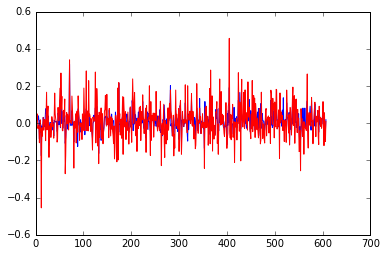

In [99]:
r2, fit = random_forst(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

## SVM

In [100]:
r2, fit = svm(pred_vars=pred_vars)
print(f"Out of sample R2 score: {r2}")

Out of sample R2 score: 0.0257297658536062
